In [55]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
%load_ext autoreload
%autoreload 2
import pandas as pd 
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
sns.set_style("white")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
df_train= pd.read_csv("https://raw.githubusercontent.com/DM-omega/Omega/main/Data/82653de5-2ed1-4782-959e-23eba75d67a9_training_data.csv")
df_train.head()

,id,keyword,location,text,target
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1


In [16]:
print('Training Set Shape = {}'.format(df_train.shape))

Training Set Shape = (6471, 5)


In [18]:
df_train.target.value_counts()

0    3701
1    2770
Name: target, dtype: int64

In [21]:
base_rate = len(df_train[df_train["target"] == 0])/len(df_train)
print(base_rate)

0.5719363313243703


In [27]:
df_train.isnull().sum()

id             0
keyword       54
location    2106
text           0
target         0
dtype: int64

In [35]:
df_train[['keyword','location']].fillna("Unknown")

,keyword,location
0,destroyed,USA
1,bioterror,Unknown
2,windstorm,"Palm Beach County, FL"
3,hazardous,USA
4,hostage,Australia
...,...,...
6466,earthquake,ARGENTINA
6467,derail,Unknown
6468,trapped,Unknown
6469,weapons,Beirut/Toronto


In [42]:
df_train['keyword'].unique()

array(['destroyed', 'bioterror', 'windstorm', 'hazardous', 'hostage',
       'landslide', 'trapped', 'weapons', 'burning%20buildings',
       'thunder', 'refugees', 'panicking', 'suicide%20bombing',
       'buildings%20on%20fire', 'seismic', 'bridge%20collapse',
       'emergency', 'body%20bags', 'wounded', 'quarantined',
       'violent%20storm', 'blight', 'destroy', 'detonation', 'ambulance',
       'armageddon', 'military', 'fatal', 'stretcher', 'devastated',
       'thunderstorm', 'hurricane', 'mudslide', 'fatalities', 'razed',
       'ruin', 'hostages', 'bioterrorism', 'cyclone', 'hazard', nan,
       'fear', 'fire%20truck', 'terrorism', 'wreckage', 'fatality',
       'forest%20fire', 'derail', 'fire', 'derailment', 'obliterated',
       'devastation', 'lightning', 'rubble', 'casualties', 'screams',
       'riot', 'wreck', 'bombing', 'wild%20fires', 'nuclear%20disaster',
       'army', 'crash', 'forest%20fires', 'disaster', 'storm', 'hellfire',
       'engulfed', 'blood', 'mass%20

In [43]:
print(df_train['keyword'].nunique())

221


In [46]:
print(df_train['location'].nunique())

2907


In [56]:
df_train = df_train.drop_duplicates(subset=['text'], keep='first')
df_train = df_train[~df_train.text.str.contains('@')]
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_URL(x))
df_train

,id,keyword,location,text,target,word_count
0,3738,destroyed,USA,Black Eye 9: A space battle occurred at Star O...,0,19
1,853,bioterror,NaN,#world FedEx no longer to transport bioterror ...,0,15
2,10540,windstorm,"Palm Beach County, FL",Reality Training: Train falls off elevated tra...,1,12
3,5988,hazardous,USA,#Taiwan Grace: expect that large rocks trees m...,1,19
4,6328,hostage,Australia,New ISIS Video: ISIS Threatens to Behead Croat...,1,17
...,...,...,...,...,...,...
6465,8330,rubble,"Calgary, AB, Canada",China's Stock Market Crash: Are There Gems In ...,1,13
6466,4377,earthquake,ARGENTINA,#Earthquake #Sismo M 1.9 - 15km E of Anchorage...,1,17
6468,9794,trapped,NaN,Hollywood Movie About Trapped Miners Released ...,1,17
6469,10344,weapons,Beirut/Toronto,Friendly reminder that the only country to eve...,1,20


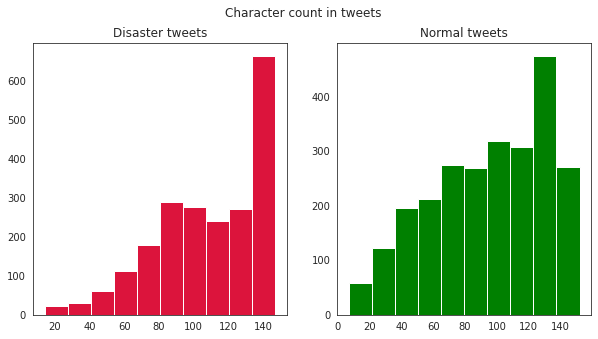

In [57]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=df_train[df_train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='crimson')
ax1.set_title('Disaster tweets')
tweet_len=df_train[df_train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Normal tweets')
fig.suptitle('Character count in tweets')
plt.show()

In [59]:
import string
import spacy
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [65]:
sp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuations = string.punctuation

def spacy_tokenizer(sentence):
    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = sp(sentence)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    return mytokens

In [72]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

X = df_train['text']
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

vectorizer_tfidf_basic = TfidfVectorizer(tokenizer=spacy_tokenizer)

classifier_basic = LogisticRegression(solver='lbfgs', max_iter=1000, random_state= 72)

pipe_basic = Pipeline([('vectorizer', vectorizer_tfidf_basic),('classifier', classifier_basic)])

pipe_basic.fit(X_train, y_train)



Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...',
                                 tokenizer=<function spacy_tokenizer at 0x7f6760e0e400>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_

In [73]:
y_pred = pipe_basic.predict(X_test)
accuracy = pipe_basic.score(X_test, y_test)
print(accuracy)

0.7944025834230355
